# Network Visualization (PyTorch)

In this notebook we will explore the use of *image gradients* for generating new images.

When training a model, we define a loss function which measures our current unhappiness with the model's performance; we then use backpropagation to compute the gradient of the loss with respect to the model parameters, and perform gradient descent on the model parameters to minimize the loss.

Here we will do something slightly different. We will start from a convolutional neural network model which has been pretrained to perform image classification on the ImageNet dataset. We will use this model to define a loss function which quantifies our current unhappiness with our image, then use backpropagation to compute the gradient of this loss with respect to the pixels of the image. We will then keep the model fixed, and perform gradient descent *on the image* to synthesize a new image which minimizes the loss.

In this notebook we will explore three techniques for image generation:

1. **Saliency Maps**: Saliency maps are a quick way to tell which part of the image influenced the classification decision made by the network.
2. **Fooling Images**: We can perturb an input image so that it appears the same to humans, but will be misclassified by the pretrained network.
3. **Class Visualization**: We can synthesize an image to maximize the classification score of a particular class; this can give us some sense of what the network is looking for when it classifies images of that class.

This notebook uses **PyTorch**; we have provided another notebook which explores the same concepts in TensorFlow. You only need to complete one of these two notebooks.

In [1]:
import torch
import torchvision
import torchvision.transforms as T
import random
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
from cs231n.image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD
from PIL import Image

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### Helper Functions

Our pretrained model was trained on images that had been preprocessed by subtracting the per-color mean and dividing by the per-color standard deviation. We define a few helper functions for performing and undoing this preprocessing. You don't need to do anything in this cell.

In [2]:
def preprocess(img, size=224):
    transform = T.Compose([
        T.Resize((size, size)),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        T.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled
    
def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

# Pretrained Model

For all of our image generation experiments, we will start with a convolutional neural network which was pretrained to perform image classification on ImageNet. We can use any model here, but for the purposes of this assignment we will use SqueezeNet [1], which achieves accuracies comparable to AlexNet but with a significantly reduced parameter count and computational complexity.

Using SqueezeNet rather than AlexNet or VGG or ResNet means that we can easily perform all image generation experiments on CPU.

[1] Iandola et al, "SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and < 0.5MB model size", arXiv 2016

In [3]:
# Download and load the pretrained SqueezeNet model.
#model = torchvision.models.squeezenet1_1(pretrained=True)
model = torchvision.models.vgg11(pretrained=True)


# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in model.parameters():
    param.requires_grad = False
    
# you may see warning regarding initialization deprecated, that's fine, please continue to next steps

## Load some ImageNet images
We have provided a few example images from the validation set of the ImageNet ILSVRC 2012 Classification dataset. To download these images, descend into `cs231n/datasets/` and run `get_imagenet_val.sh`.

Since they come from the validation set, our pretrained model did not see these images during training.

Run the following cell to visualize some of these images, along with their ground-truth labels.

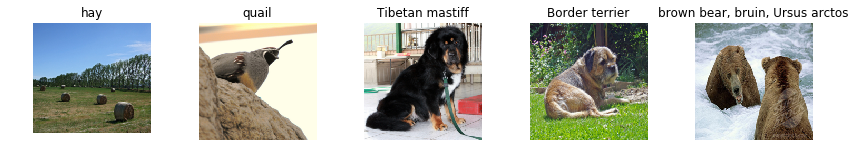

In [4]:
from cs231n.data_utils import load_imagenet_val
X, y, class_names = load_imagenet_val(num=5)

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

In [5]:
X.shape

(5, 224, 224, 3)

In [6]:
X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)

In [7]:
y = torch.LongTensor([1, 2, 1, 3, 1])

In [8]:
scores = model(X_tensor)
scores.shape

torch.Size([5, 1000])

In [9]:
s = scores.gather(1, y.view(-1, 1)).squeeze() 
s

tensor([-7.7784, -2.2869, -2.1845, -6.5630, -5.8002])

In [10]:
for i in range(5):
    print(s[i].item(), type(s[i]))

-7.77836799621582 <class 'torch.Tensor'>
-2.286928653717041 <class 'torch.Tensor'>
-2.1845180988311768 <class 'torch.Tensor'>
-6.562970161437988 <class 'torch.Tensor'>
-5.800194263458252 <class 'torch.Tensor'>


# 3. GradCAM

In [62]:
torchvision.models.vgg19(pretrained=True)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [50]:
import torch 
import torch.nn as nn

class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        # get the pretrained VGG19 network
        self.vgg = torchvision.models.vgg19(pretrained=True)
        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:36]
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        # register the hook
        h = x.register_hook(self.activations_hook)
        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

In [51]:
from PIL import Image
img = Image.open("car.jpg")
img = preprocess(img)

In [52]:
img.shape

torch.Size([1, 3, 224, 224])

In [53]:
# initialize the VGG model
vgg = VGG()

# set the evaluation mode
vgg.eval()

# get the most likely prediction of the model
#pred = vgg(img).argmax(dim=1)
pred = vgg(img)
print(pred.shape)

torch.Size([1, 1000])


torch.Size([1, 512, 14, 14])


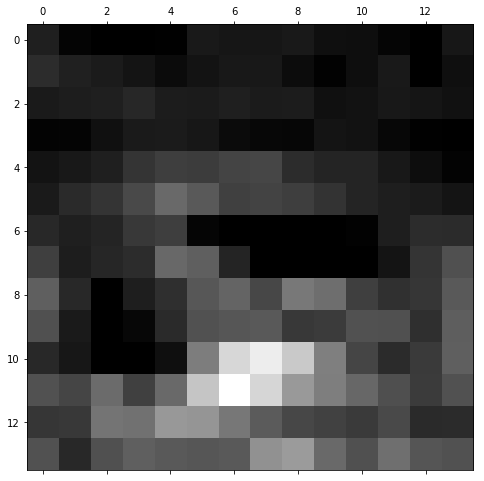

In [54]:
# get the gradient of the output with respect to the parameters of the model
pred[:, 817].backward()

# pull the gradients out of the model
gradients = vgg.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = vgg.get_activations(img).detach()
print(activations.shape)

# weight the channels by corresponding gradients
for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

In [55]:
heatmap = heatmap.numpy()
print(heatmap.shape)

(14, 14)


In [56]:
import cv2
img = cv2.imread("car.jpg")
img = cv2.resize(img, (224, 224)) 
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
#cv2.imwrite('./map.jpg', superimposed_img)

In [57]:
superimposed_img.shape

(224, 224, 3)

In [58]:
superimposed_img = superimposed_img[:, :, ::-1]
superimposed_img = superimposed_img / np.max(superimposed_img)

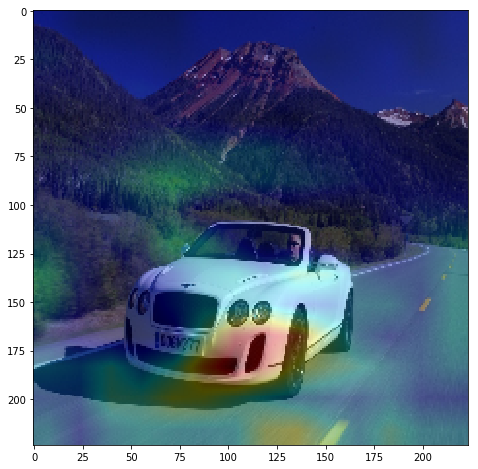

In [61]:
plt.imshow(superimposed_img)

# 4. Perturb explanations

In [5]:
import torch
from torch.autograd import Variable
from torchvision import models
import cv2
import sys
import numpy as np
%matplotlib inline

In [6]:
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

In [7]:
def tv_norm(input, tv_beta):
    img = input[0, 0, :]
    row_grad = torch.mean(torch.abs((img[:-1 , :] - img[1 :, :])).pow(tv_beta))
    col_grad = torch.mean(torch.abs((img[: , :-1] - img[: , 1 :])).pow(tv_beta))
    return row_grad + col_grad

In [8]:
# Download and load the pretrained SqueezeNet model.
#model = torchvision.models.squeezenet1_1(pretrained=True)
#model = torchvision.models.vgg19(pretrained=True)
#model = torchvision.models.vgg16(pretrained=True)
model = models.vgg11(pretrained=True)
#model = models.googlenet(pretrained=True)
# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in model.parameters():
    param.requires_grad = False
# you may see warning regarding initialization deprecated, that's fine, please continue to next steps

In [9]:
tv_beta = 1
learning_rate = 0.1
max_iterations = 200
l1_coeff = 10
tv_coeff = 45
pred_coeff = 0.2

In [265]:
from PIL import Image
img = Image.open("car.jpg")
#img = Image.open("player.jpg")
#img = Image.open("bear.jpg")
#img = Image.open("flute.jpg")
#img = Image.open("kitten.jpg")
#img = Image.open("puppy.jpg")
#img = np.array(img)

In [266]:
type(img)

PIL.JpegImagePlugin.JpegImageFile

In [267]:
#img = preprocess(img).cpu().data.numpy().astype(np.float32)
img = preprocess(img)

In [268]:
print(img.shape)

torch.Size([1, 3, 224, 224])


In [225]:
img = deprocess(img)

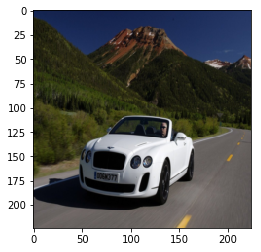

In [226]:
plt.imshow(img)

In [51]:
blurred_img1 = cv2.GaussianBlur(img, (21, 21), 15, 15)
#blurred_img1 = cv2.medianBlur(img, 11)
plt.imshow(blurred_img1)

error: OpenCV(3.4.2) /opt/concourse/worker/volumes/live/9523d527-1b9e-48e0-7ed0-a36adde286f0/volume/opencv-suite_1535558719691/work/modules/core/src/matrix.cpp:755: error: (-215:Assertion failed) dims <= 2 && step[0] > 0 in function 'locateROI'


In [293]:
mask_init = np.ones((1, 1, 28, 28), dtype = np.float32)
mask = torch.tensor(mask_init, requires_grad=True)

In [294]:
# Convert to torch variables
img = preprocess(Image.fromarray(img))
blurred_img = preprocess(Image.fromarray(blurred_img1))

In [295]:
print(img.shape)
print(mask.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 1, 28, 28])


In [296]:
optimizer = torch.optim.Adam([mask], lr=learning_rate)

In [297]:
target = model(img)
print(target.shape)
category = np.argmax(target.cpu().data.numpy())
print(category)
print ("Category with highest probability", class_names[category])

torch.Size([1, 1000])
817
Category with highest probability sports car, sport car


In [298]:
def deprocess_withoutnorm(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def visualize_heatmap(t):
    # t shape: 1*1*28*28
    m = t.cpu().data.numpy()[0]
    # 1*28*28
    m = np.transpose(m, (1, 2, 0))
    # 28*28*1
    m = np.squeeze(m)       
    # 28*28
    m = np.stack((m,)*3, axis=-1)
    plt.figure()
    plt.imshow(m, cmap=plt.cm.hot)
    plt.show()
    
def visualize_image(t):
    m = t.clone()
    m = deprocess(m, should_rescale=True)
    plt.figure()
    plt.imshow(m)
    plt.show()
    
def visualize_tensor(t):
    m = t.clone()
    m = deprocess_withoutnorm(m, should_rescale=True)
    plt.figure()
    plt.imshow(m)
    plt.show()

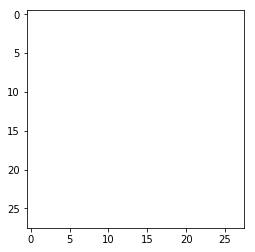

In [299]:
visualize_heatmap(mask)

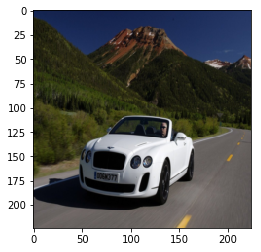

In [300]:
visualize_image(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


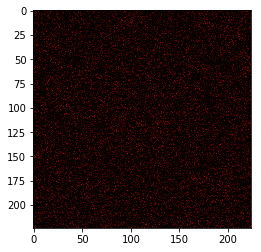

In [301]:
noise = np.zeros((224, 224, 3), dtype = np.float32)
cv2.randn(noise, 0, 0.2)
plt.imshow(noise)

Iteration: 0


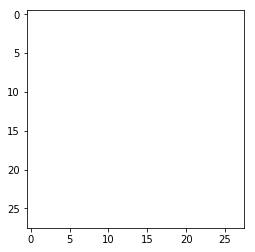

0.0 0.0 16.249528884887695 -1.6360225677490234
Iteration: 10


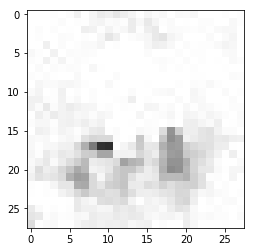

0.5330910682678223 2.8277409076690674 14.863431930541992 -1.7423536777496338
Iteration: 20


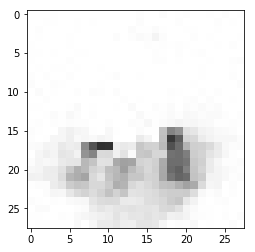

0.5818849802017212 2.3709583282470703 14.637581825256348 -2.483440399169922
Iteration: 30


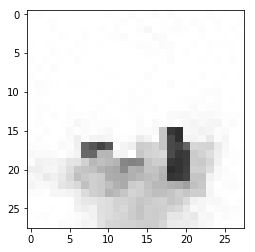

0.698750376701355 2.5026912689208984 14.062715530395508 -1.8296873569488525
Iteration: 40


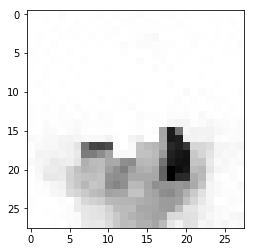

0.8931546807289124 2.7216808795928955 10.480711936950684 -2.4232659339904785
Iteration: 50


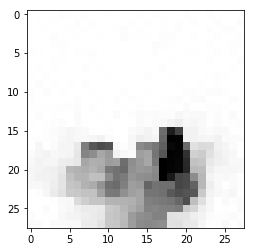

1.0923488140106201 3.0612547397613525 9.352459907531738 -2.9312150478363037
Iteration: 60


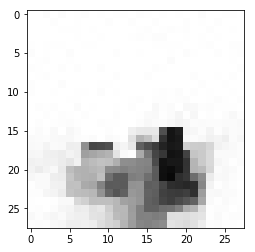

1.2019321918487549 3.223799228668213 9.99685001373291 -2.6312930583953857
Iteration: 70


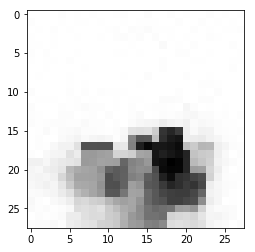

1.323496699333191 3.4268248081207275 11.236175537109375 -2.1890950202941895
Iteration: 80


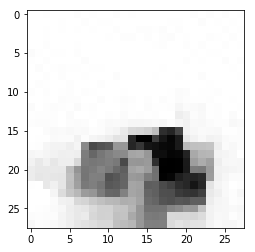

1.4268101453781128 3.476130247116089 9.762386322021484 -2.1358587741851807
Iteration: 90


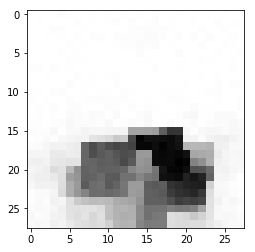

1.5642666816711426 3.428561210632324 9.549871444702148 -2.154271125793457
Iteration: 100


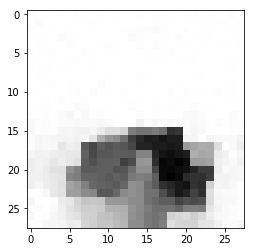

1.6182467937469482 3.382995843887329 9.357954025268555 -2.889460563659668
Iteration: 110


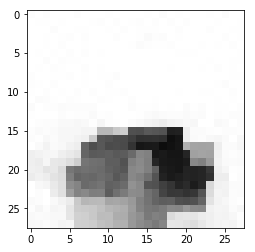

1.6247938871383667 3.3085436820983887 12.28020191192627 -2.74481463432312
Iteration: 120


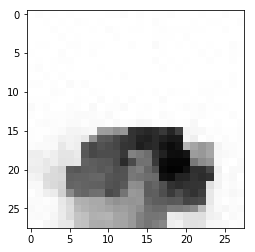

1.724337100982666 3.458829879760742 11.240330696105957 -3.3382210731506348
Iteration: 130


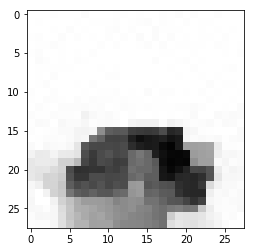

1.8199896812438965 3.51606822013855 10.453593254089355 -3.1705381870269775
Iteration: 140


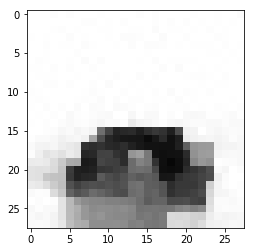

1.921759843826294 3.642479181289673 7.81453800201416 -2.447218894958496
Iteration: 150


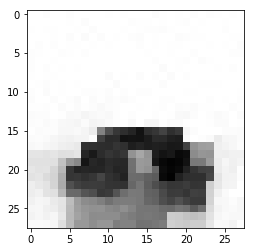

1.980553388595581 3.7242894172668457 11.458849906921387 -2.800804853439331
Iteration: 160


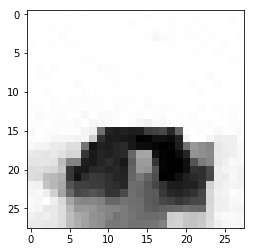

2.0688912868499756 3.801077365875244 10.158385276794434 -2.798290967941284
Iteration: 170


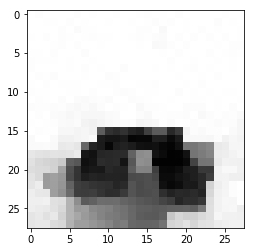

2.1620190143585205 3.836998224258423 6.277804851531982 -2.475564479827881
Iteration: 180


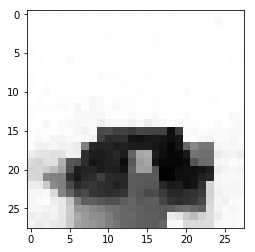

2.12776255607605 4.0069146156311035 7.419894695281982 -2.7546610832214355
Iteration: 190


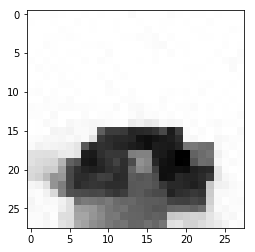

2.0686304569244385 3.8074140548706055 6.673618793487549 -2.5757131576538086


In [302]:
for i in range(max_iterations):
    # upsample mask
    upsampled_mask = torch.nn.functional.interpolate(mask, size=(224, 224), mode='bilinear', align_corners=True)
    upsampled_mask = torch.cat((upsampled_mask,upsampled_mask,upsampled_mask),1)
    # Perturbation: Blur
    perturbated_input = img.mul(upsampled_mask) + blurred_img.mul(1-upsampled_mask)
    # Perturbation: Noise 
    noise = np.zeros((224, 224, 3), dtype = np.float32)
    cv2.randn(noise, 0, 0.2)
    noise = np.transpose(noise , (2, 0, 1))
    noise = torch.tensor(noise)
    noise = noise.expand(1, 3, 224, 224)
    perturbated_input = perturbated_input + noise.mul(1-upsampled_mask)
    #perturbated_input = perturbated_input + noise
    # Perturbation: Constant
    #constant = torch.mean(img).item()
    #constant_matrix = np.full(perturbated_input.size(), constant, dtype = np.float32)
    #constant_matrix = torch.tensor(constant_matrix)
    #perturbated_input = perturbated_input + constant_matrix.mul(1-upsampled_mask)
    # masked region
    masked_input = img.mul(1-upsampled_mask) + blurred_img.mul(upsampled_mask)
    # forward pass 
    outputs = model(perturbated_input)
    masked_outputs = model(masked_input)
    loss1 = l1_coeff*torch.mean(torch.abs(1 - mask)) 
    loss2 = tv_coeff*tv_norm(mask, tv_beta) 
    loss3 = outputs[0, category]
    loss4 = pred_coeff*masked_outputs[0, category]
    loss = loss1+loss2+loss3+(-loss4)
    if i%10 == 0:
        print("Iteration:", i)
        # show mask during training
        visualize_heatmap(mask)
        #visualize_image(perturbated_input)
        #visualize_image(masked_input)
        print(loss1.item(), loss2.item(), loss3.item(), -loss4.item())
    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Optional: clamping seems to give better results
    mask.data.clamp_(0, 1)

In [303]:
upsampled_mask.shape

torch.Size([1, 3, 224, 224])

In [304]:
mask = upsampled_mask.cpu().data.numpy()[0]
mask = np.squeeze(mask)
mask = np.transpose(mask, (1, 2, 0))
mask = (mask - np.min(mask)) / np.max(mask)
#mask = 1 - mask
heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255

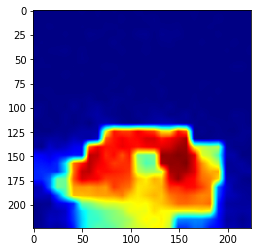

In [305]:
plt.imshow(heatmap)

In [306]:
img = Image.open("car.jpg")
img = np.array(img)
img = preprocess(Image.fromarray(img))
img = np.squeeze(img)    
img = np.transpose(img, (1, 2, 0))
img = img.cpu().data.numpy()
#img = deprocess(img, should_rescale=True)

In [307]:
img.shape

(224, 224, 3)

In [308]:
cam = (heatmap*1 + img) * 255
cam = cam / np.max(cam)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


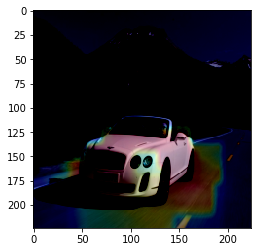

In [309]:
plt.imshow(cam)